In [32]:
import pandas as pd
import requests

Расчет метрик

In [33]:
visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
registrations = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')

In [34]:
v = visits.json()
r = registrations.json()
df_visits = pd.DataFrame(v)
df_reg = pd.DataFrame(r)

In [35]:
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
df_visits['datetime'] = df_visits['datetime'].dt.strftime('%Y-%m-%d')

df_reg['datetime'] = pd.to_datetime(df_reg['datetime'])
df_reg['datetime'] = df_reg['datetime'].dt.strftime('%Y-%m-%d')

In [36]:
df_visits = df_visits.drop_duplicates(subset=['visit_id'], keep='last')
df_visits = df_visits[~df_visits['user_agent'].str.contains('bot', case=False)]
visits_grouped = df_visits.groupby(['datetime', 'platform']).size().reset_index(name='visits')
registrations_grouped = df_reg.groupby(['datetime', 'platform']).size().reset_index(name='registrations')
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['datetime', 'platform'], how='outer')
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100
merged_df = merged_df.rename(columns={'datetime': 'date_group'})
merged_df = merged_df.fillna(0)
merged_df.to_json('conversion.json')

Рекламы

In [37]:
url = 'https://github.com/Filippova-Anna/data-analytics-project-100/blob/main/ads.csv?raw=true'
ads = pd.read_csv(url)

In [38]:
ads['date'] = pd.to_datetime(ads['date'])
ads['date'] = ads['date'].dt.strftime('%Y-%m-%d')

ads = ads.sort_values(by='date')
conversion_df = pd.read_json('conversion.json')
df = pd.merge(conversion_df, ads, left_on='date_group', right_on='date', how='left')
df['utm_campaign'] = df['utm_campaign'].fillna('none')
df['cost'] = df['cost'].fillna(0)
final_df = df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
final_df.to_json('ads.json')

Визуализация

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

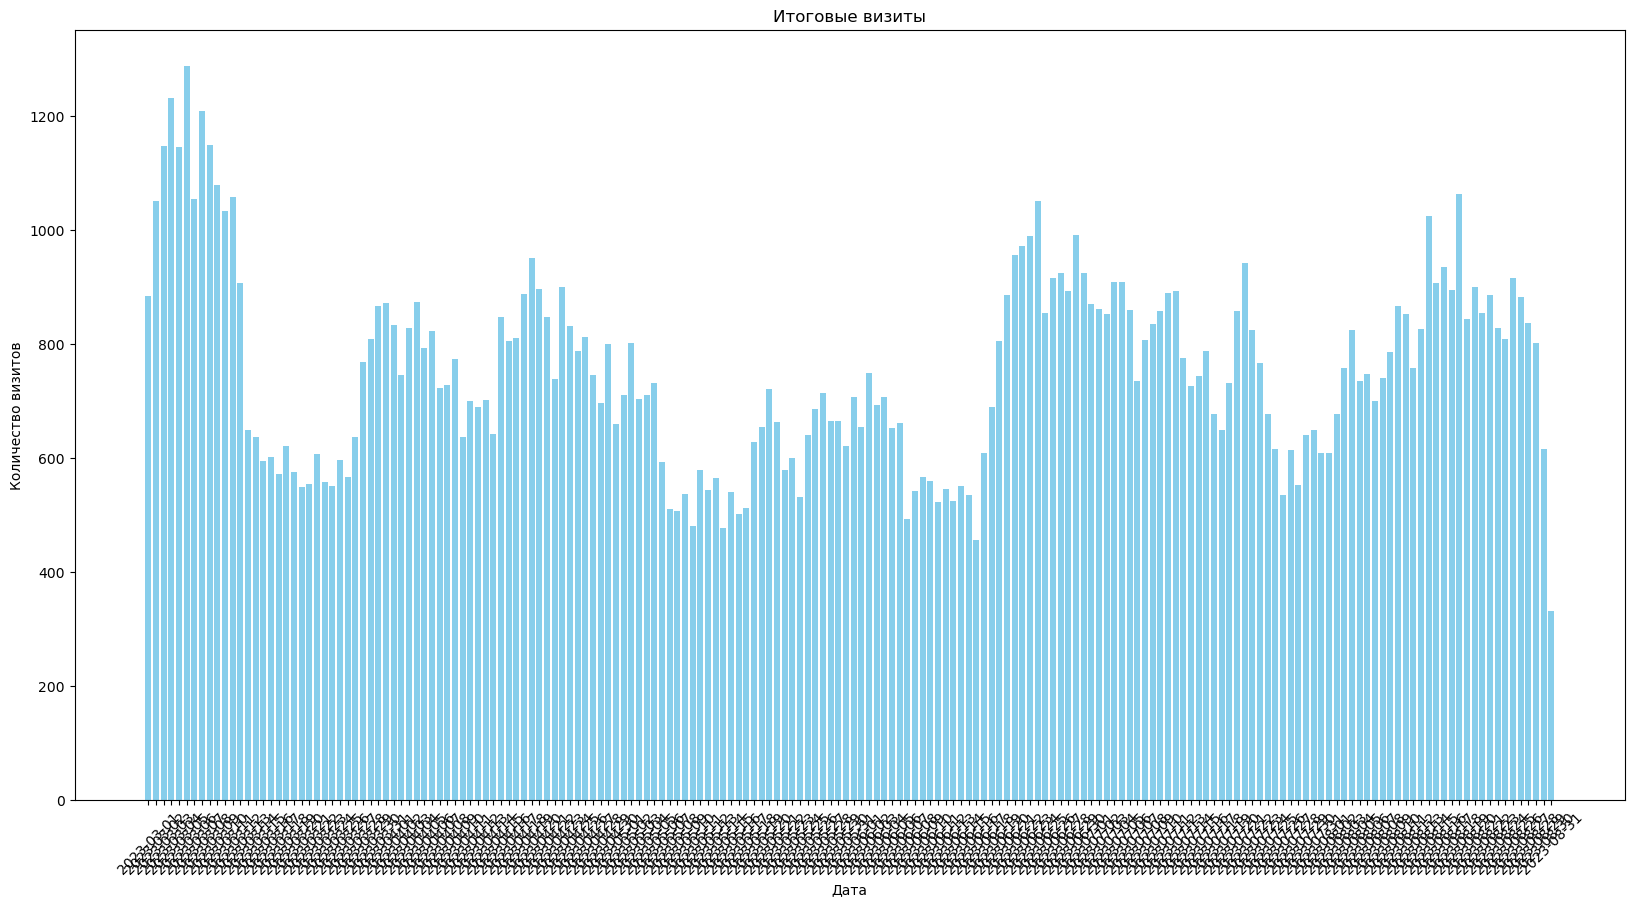

In [40]:
grouped_visits = final_df.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(20, 10))
plt.bar(grouped_visits['date_group'], grouped_visits['visits'], color='skyblue')
plt.title('Итоговые визиты')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.xticks(rotation=45)
plt.savefig('./charts/total_visits.png')
plt.show()

<Figure size 2000x500 with 0 Axes>

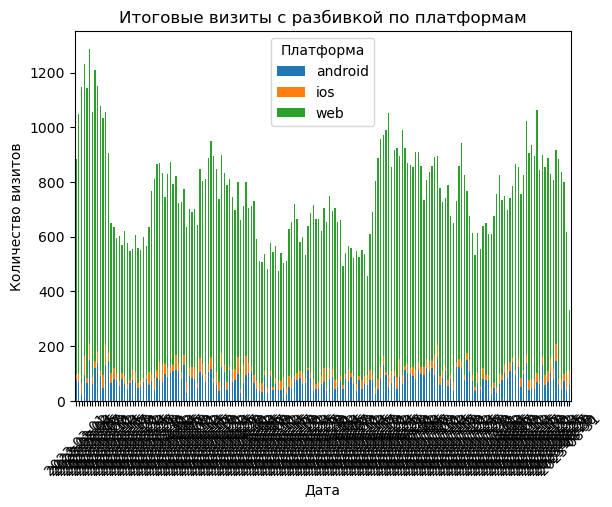

In [41]:
grouped_visits_platform = merged_df.groupby(['date_group', 'platform'])['visits'].sum().unstack().fillna(0)

plt.figure(figsize=(20, 5))
grouped_visits_platform.plot(kind='bar', stacked=True)
plt.title('Итоговые визиты с разбивкой по платформам')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.xticks(rotation=45)
plt.legend(title='Платформа')
plt.savefig('./charts/total_visits_by_platform_stacked_barplot.png')
plt.show()

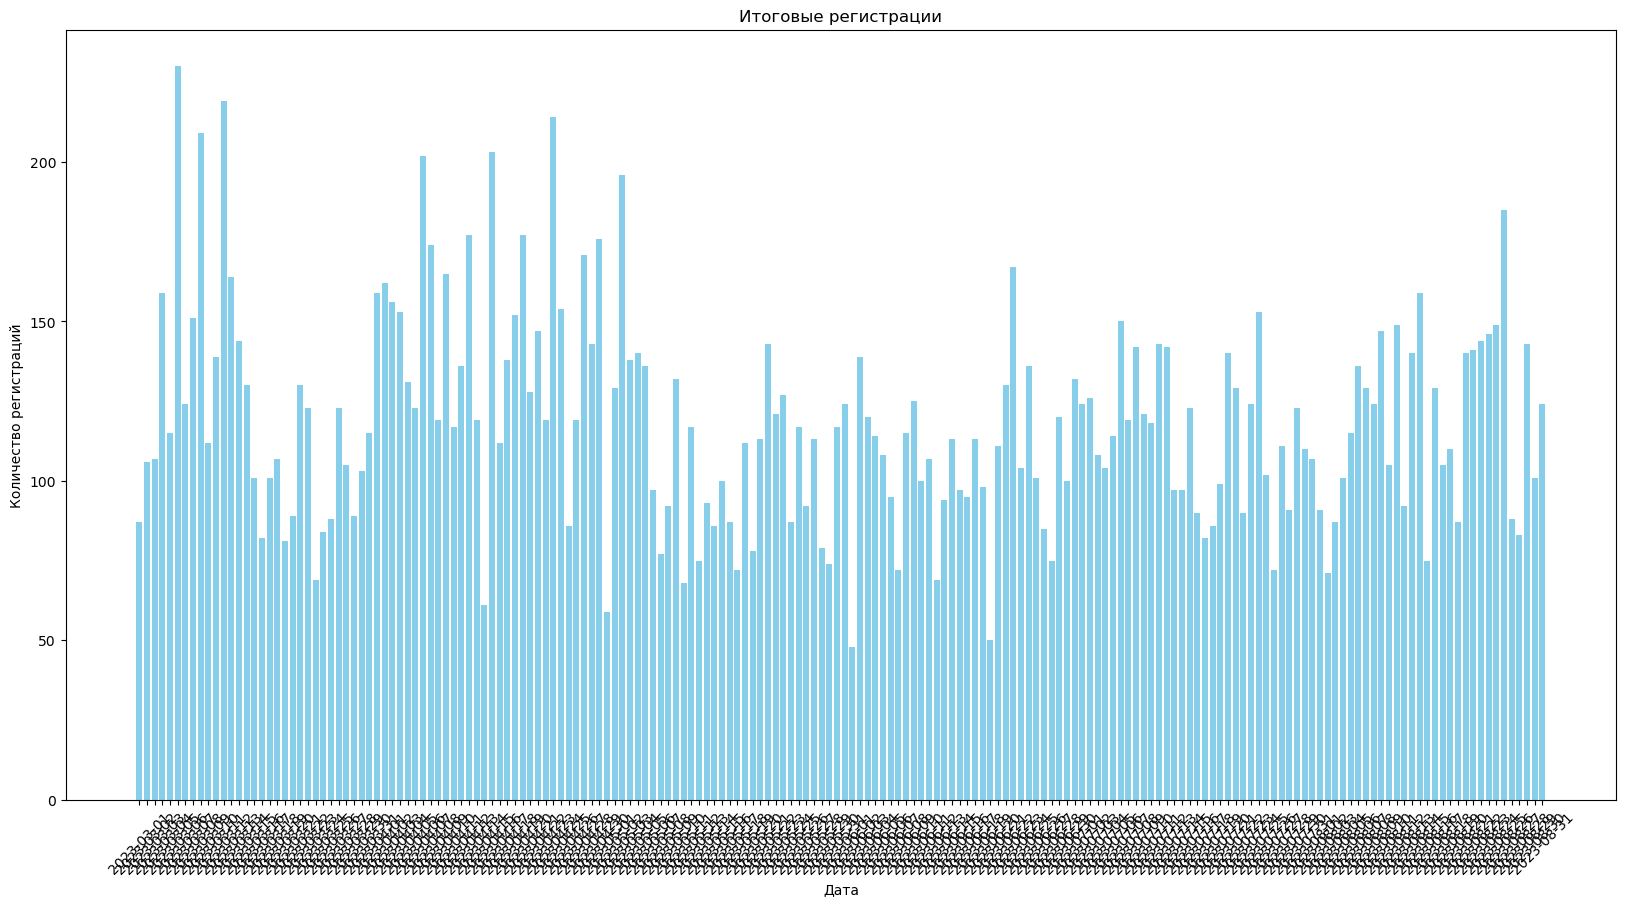

In [42]:
grouped_reg = final_df.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(20, 10))
plt.bar(grouped_reg['date_group'], grouped_reg['registrations'], color='skyblue')
plt.title('Итоговые регистрации')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.xticks(rotation=45)
plt.savefig('./charts/total_registrations.png')
plt.show()

<Figure size 2000x1000 with 0 Axes>

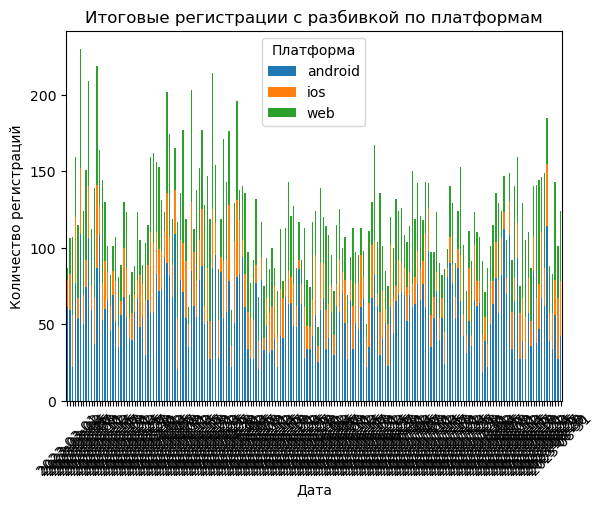

In [43]:
grouped_reg_platform = merged_df.groupby(['date_group', 'platform'])['registrations'].sum().unstack().fillna(0)
plt.figure(figsize=(20, 10))
grouped_reg_platform.plot(kind='bar', stacked=True)
plt.title('Итоговые регистрации с разбивкой по платформам')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.xticks(rotation=45)
plt.legend(title='Платформа')
plt.savefig('./charts/total_registration_by_platform_stacked_barplot.png')
plt.show()

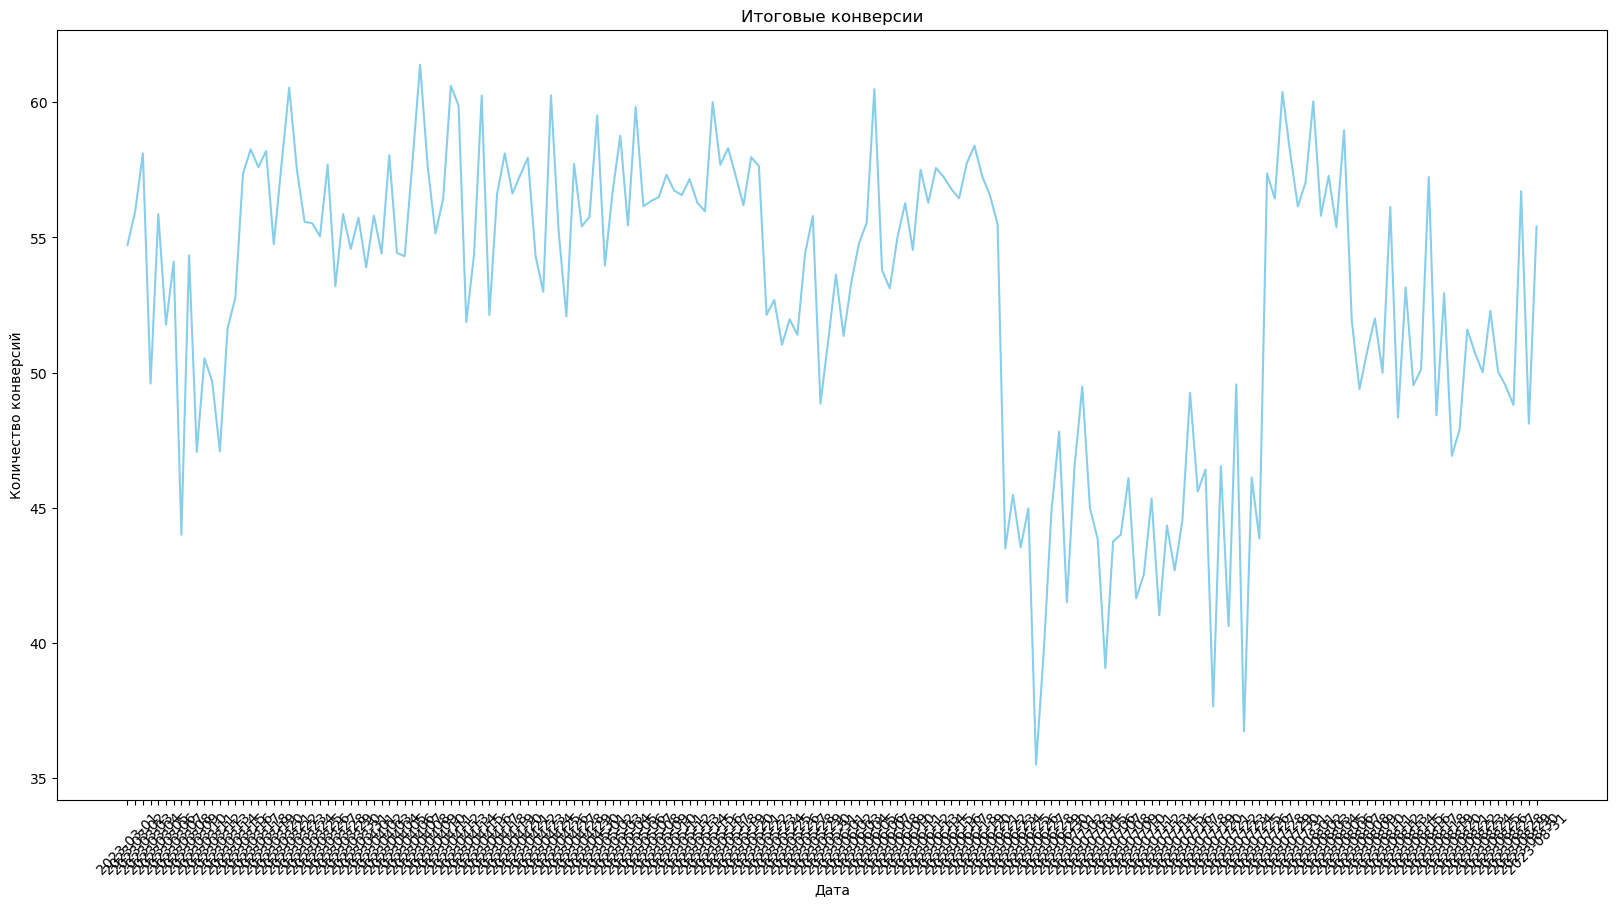

In [44]:
grouped_conv = merged_df.groupby('date_group')['conversion'].agg('mean').reset_index()

plt.figure(figsize=(20, 10))
plt.plot(grouped_conv['date_group'], grouped_conv['conversion'], color='skyblue')
plt.title('Итоговые конверсии')
plt.xlabel('Дата')
plt.ylabel('Количество конверсий')
plt.xticks(rotation=45)
plt.savefig('./charts/conversion.png')
plt.show()

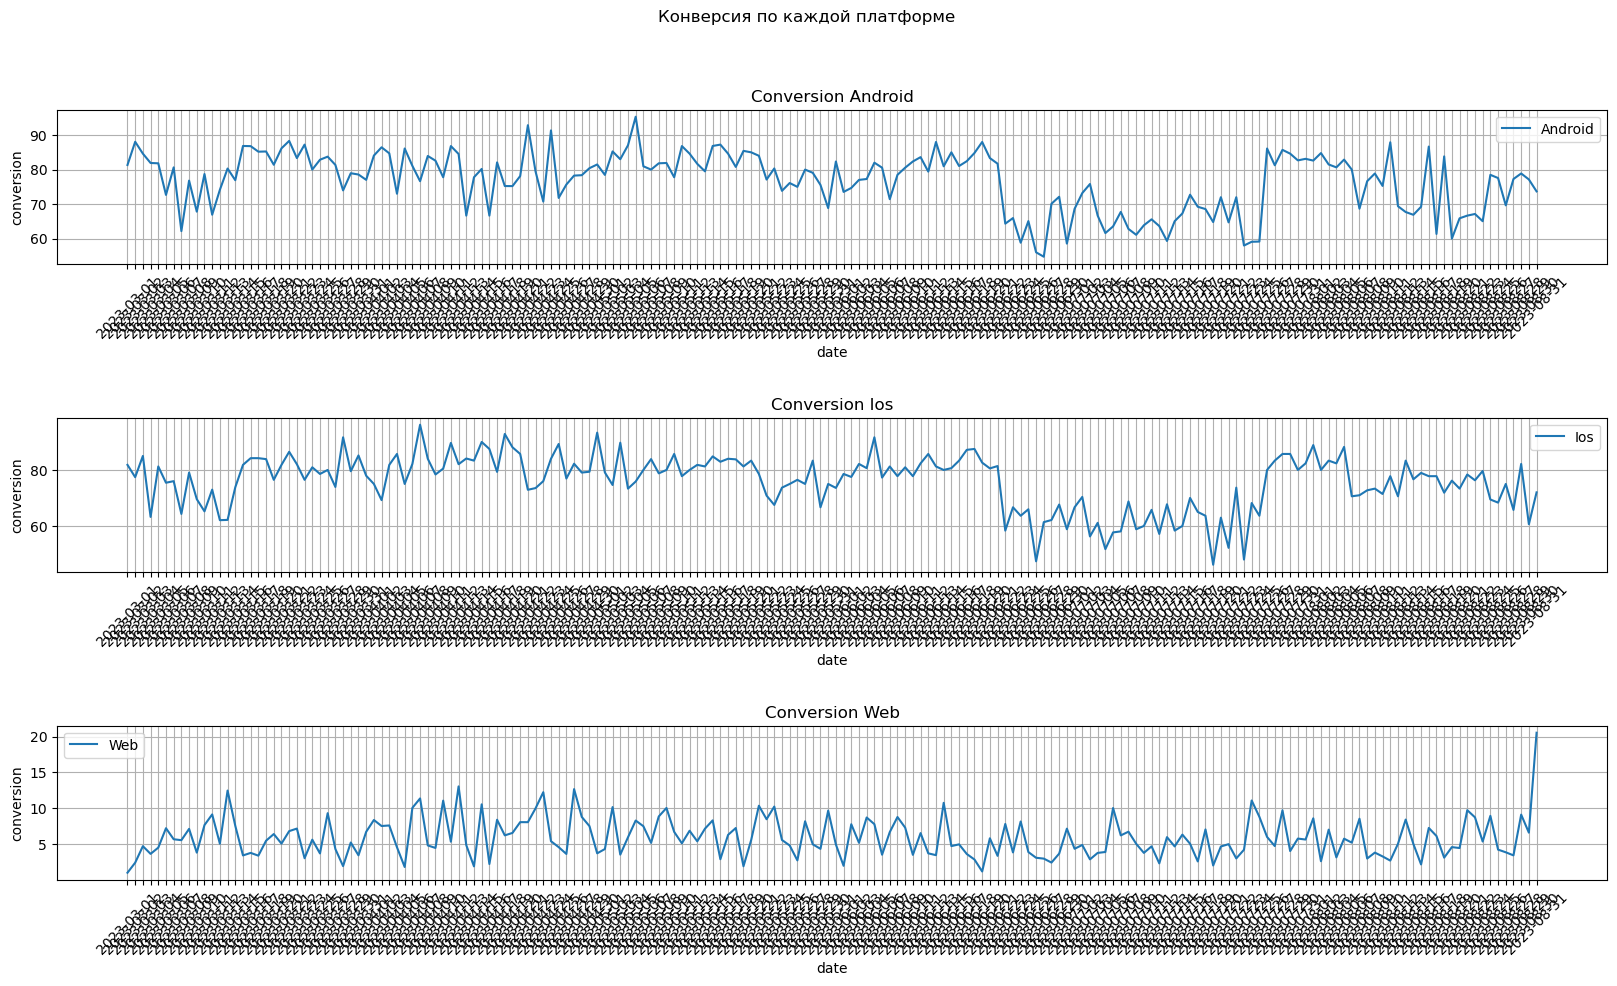

In [45]:
grouped_conv_platform = merged_df.groupby(['date_group', 'platform'])['conversion'].sum().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(3, 1)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=1.5, hspace=1)
fig.suptitle('Конверсия по каждой платформе', fontsize=12)

axes[0].plot(grouped_conv_platform['date_group'], grouped_conv_platform['android'], label='Android')
axes[0].legend()
axes[0].set_title('Conversion Android')
axes[0].set_xlabel('date')
axes[0].set_ylabel('conversion')
axes[0].set_xticks(grouped_conv_platform['date_group'])
axes[0].set_xticklabels(grouped_conv_platform['date_group'], rotation=45)
axes[0].grid()

axes[1].plot(grouped_conv_platform['date_group'], grouped_conv_platform['ios'], label='Ios')
axes[1].legend()
axes[1].set_title('Conversion Ios')
axes[1].set_xlabel('date')
axes[1].set_ylabel('conversion')
axes[1].set_xticks(grouped_conv_platform['date_group'])
axes[1].set_xticklabels(grouped_conv_platform['date_group'], rotation=45)
axes[1].grid()

axes[2].plot(grouped_conv_platform['date_group'], grouped_conv_platform['web'], label='Web')
axes[2].legend()
axes[2].set_title('Conversion Web')
axes[2].set_xlabel('date')
axes[2].set_ylabel('conversion')
axes[2].set_xticks(grouped_conv_platform['date_group'])
axes[2].set_xticklabels(grouped_conv_platform['date_group'], rotation=45)
axes[2].grid()

plt.savefig('./charts/conversion_by_platform.png')
plt.show()

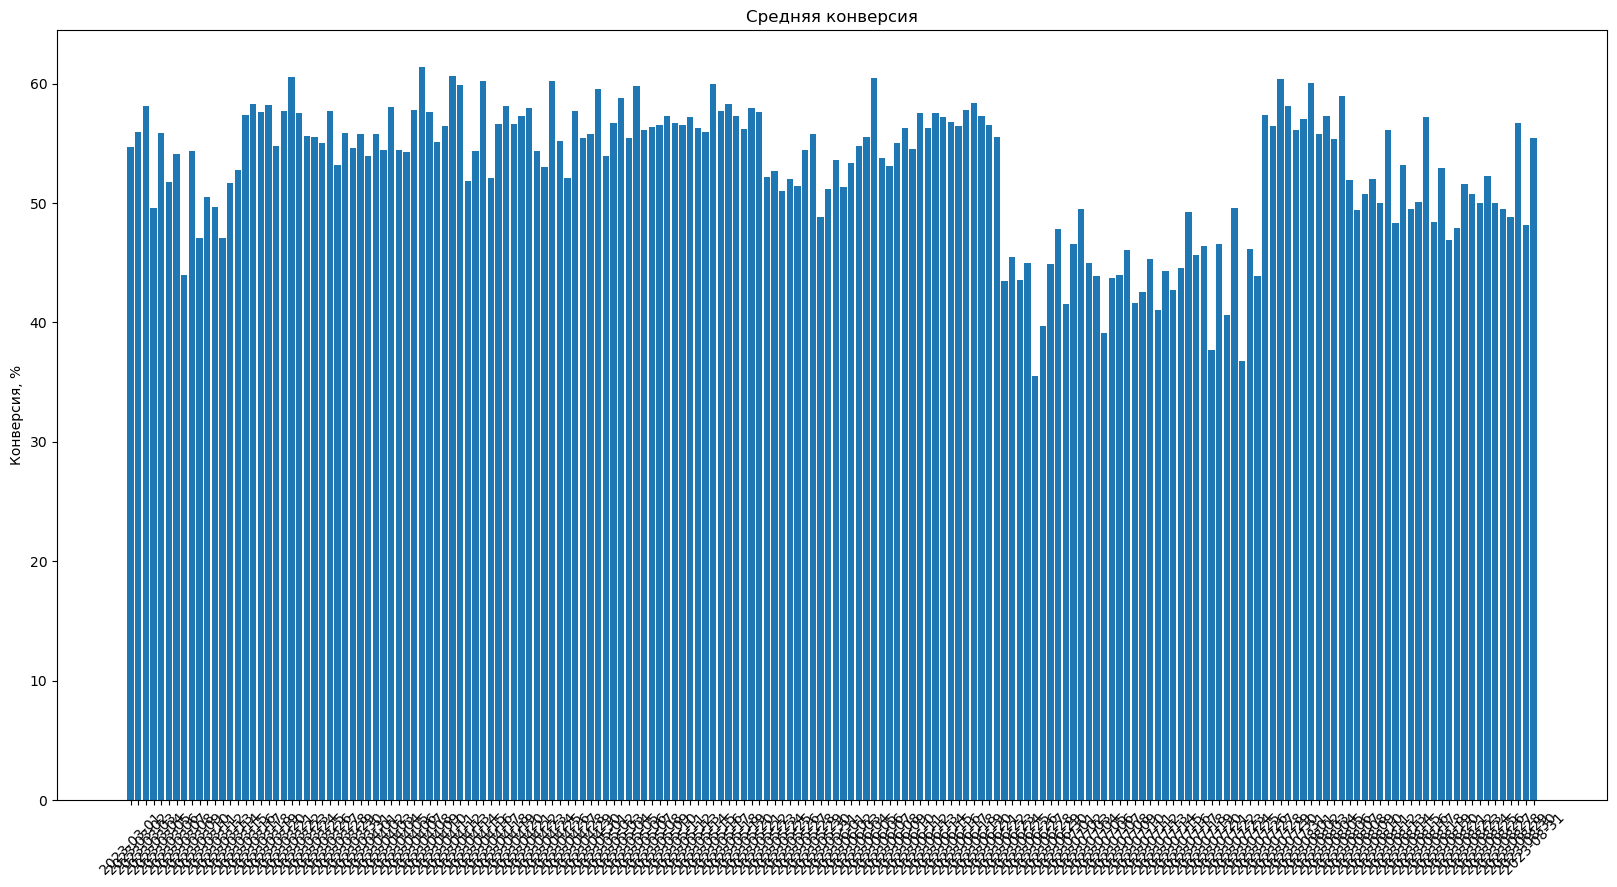

In [46]:
grouped_mean_conv = merged_df.groupby('date_group')['conversion'].mean().reset_index()

plt.figure(figsize=(20, 10))
plt.bar(grouped_mean_conv['date_group'], grouped_mean_conv['conversion'])
plt.title('Средняя конверсия')
plt.ylabel('Конверсия, %')
plt.xticks(rotation=45)
plt.savefig('./charts/average_conversion.png')
plt.show()

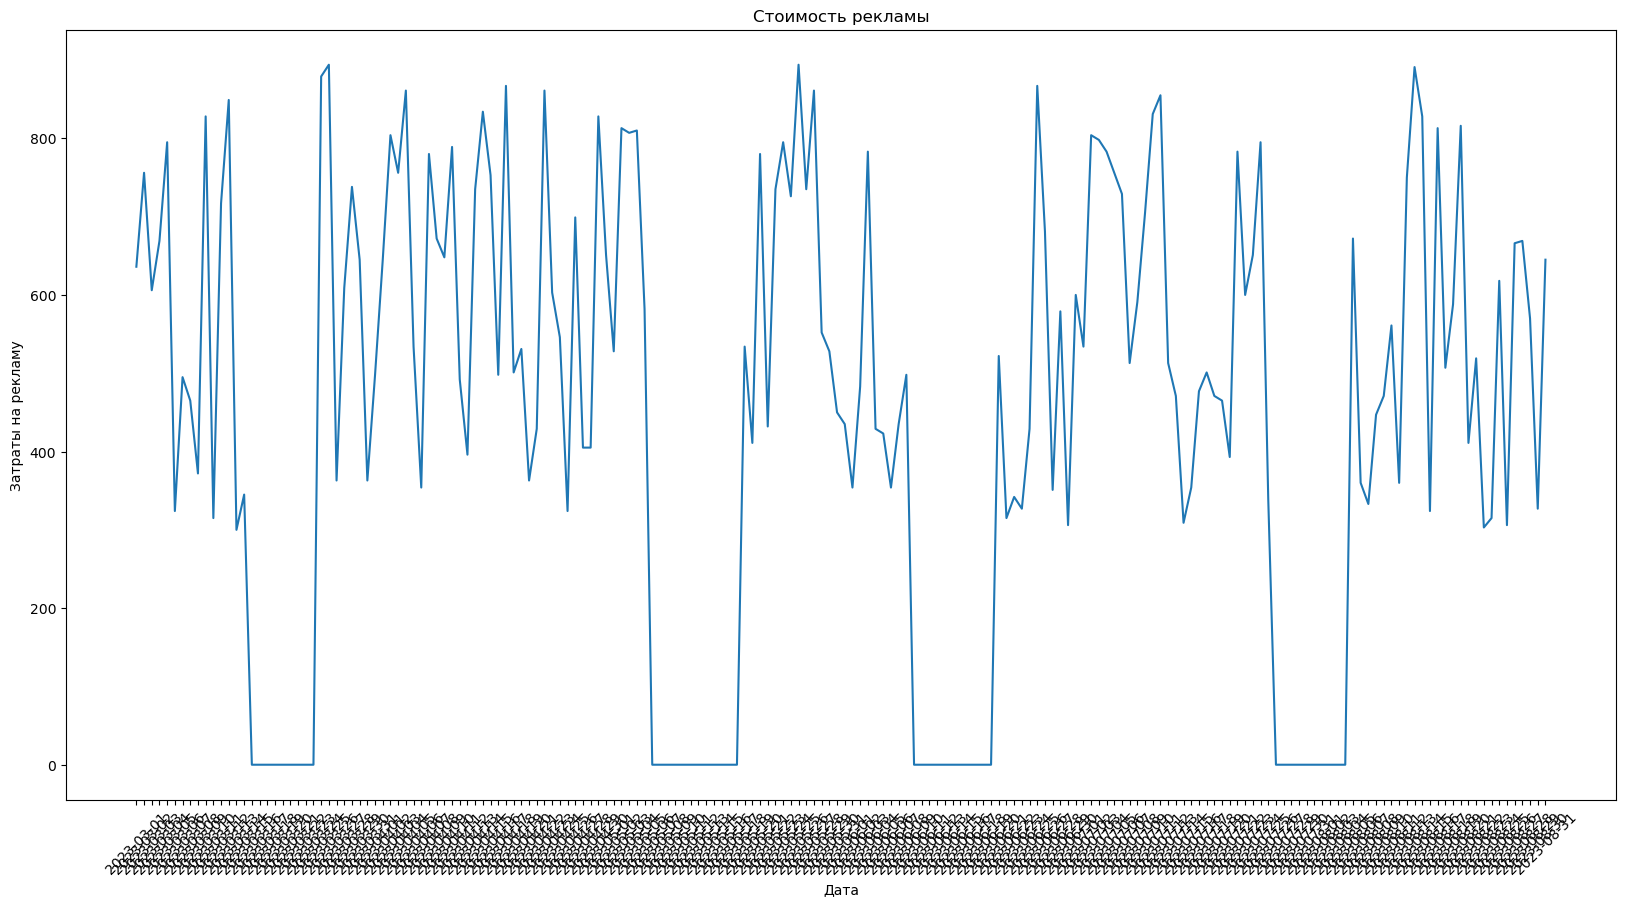

In [47]:
grouped_cost = final_df.groupby('date_group')['cost'].sum().reset_index()

plt.figure(figsize=(20, 10))
plt.plot(grouped_cost['date_group'], grouped_cost['cost'])
plt.title('Стоимость рекламы')
plt.xlabel('Дата')
plt.ylabel('Затраты на рекламу')
plt.xticks(rotation=45)
plt.savefig('./charts/advertising_costs.png')
plt.show()

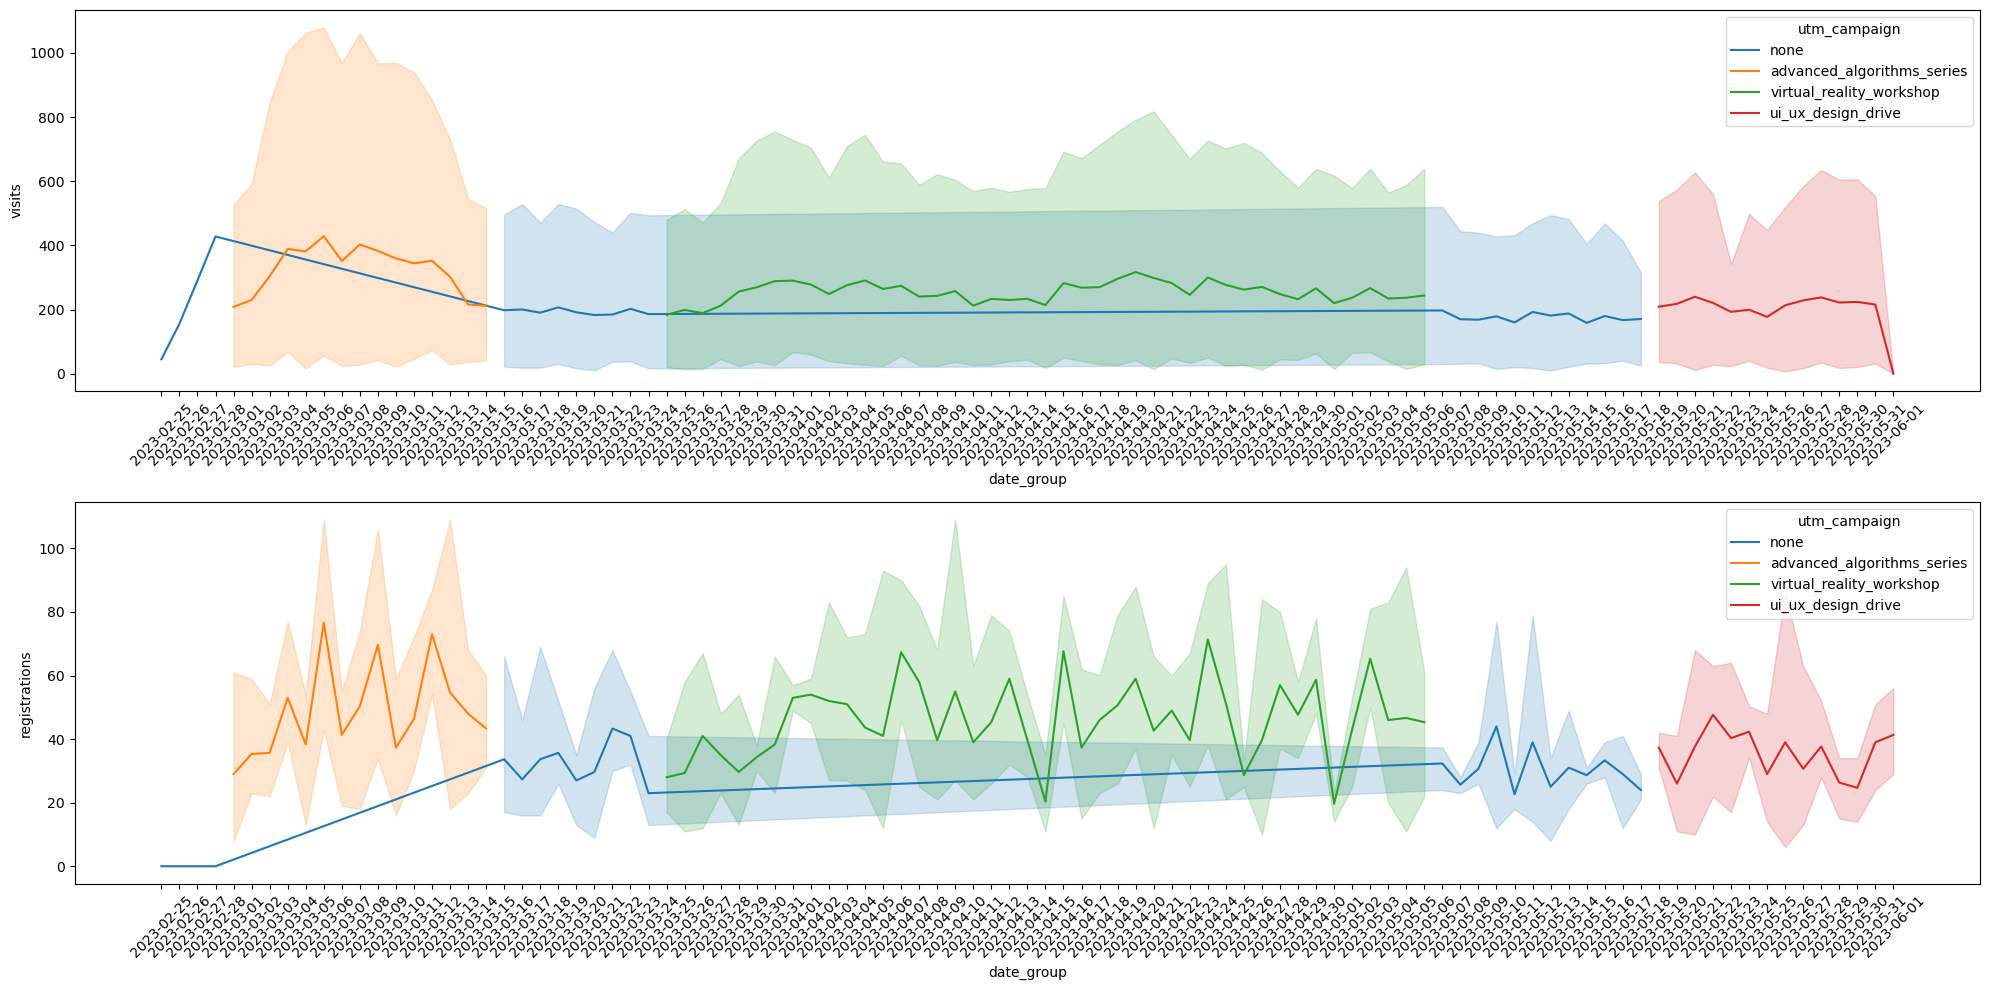

In [17]:
f, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw=dict(width_ratios=[1]))
my_plot= sns.lineplot(data=final_df, x="date_group", y="visits", hue="utm_campaign", ax=axs[0])
my_plot_2 = sns.lineplot(data=final_df, x='date_group', y='registrations', hue="utm_campaign", ax=axs[1])
my_plot.set_xticks(my_plot.get_xticks())
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
my_plot_2.set_xticks(my_plot_2.get_xticks())
my_plot_2.set_xticklabels(my_plot_2.get_xticklabels(), rotation=45)
f.tight_layout()
plt.savefig('./charts/registrations_and_registartions.png')
plt.show()